# In this notebook I will show you how to accurately decode real image.

##Loading FFHQ e4e encoder

* importing necessary libraries

In [106]:
from argparse import Namespace
import time
import os
import sys
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


* Downloading model by link

In [70]:
!pip install gdown

file_id = '1cUv_reLE6k3604or78EranS7XzuVMWeO'
output_name = 'model.pth'

import gdown
gdown.download(f'https://drive.google.com/uc?id={file_id}', output_name, quiet=False)

import torch

model_path = output_name  # Path to the downloaded model file
ckpt = torch.load(model_path, map_location='cpu')

# Print the keys of the checkpoint to confirm successful loading
print(ckpt.keys())


Downloading...
From (original): https://drive.google.com/uc?id=1cUv_reLE6k3604or78EranS7XzuVMWeO
From (redirected): https://drive.google.com/uc?id=1cUv_reLE6k3604or78EranS7XzuVMWeO&confirm=t&uuid=3ab9a900-1a7c-4612-8c70-45849b0f14e4
To: /content/encoder4editing/StyleCLIP-Tutorial/model.pth
100%|██████████| 1.20G/1.20G [00:16<00:00, 70.7MB/s]


dict_keys(['state_dict', 'latent_avg', 'opts'])


* Loading encoder model

In [48]:
opts = ckpt['opts']
opts['checkpoint_path'] = model_path
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Loading e4e over the pSp framework from checkpoint: model.pth
Model successfully loaded!


## Image preprocessing

* Visualizing real initial image:

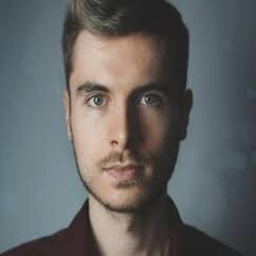

In [97]:
image_path = '/content/face2.jpg'
original_image = Image.open(image_path)
original_image = original_image.convert("RGB")
resize_dims = (256, 256)
original_image.resize(resize_dims)

* Image alignment

Aligned image has shape: (256, 256)


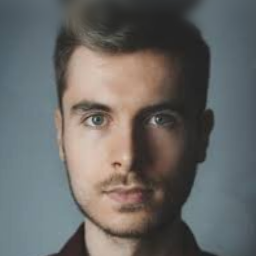

In [94]:
if 'shape_predictor_68_face_landmarks.dat' not in os.listdir():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

def run_alignment(image_path):
  import dlib
  from utils.alignment import align_face
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor)
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image

input_image = run_alignment('/content/face2.jpg')


input_image.resize(resize_dims)

In [131]:
transform_img = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
transformed_image = transform_img(input_image)

In [132]:
def display_alongside_source_image(result_image, source_image):
    res = np.concatenate([np.array(source_image.resize(resize_dims)),
                          np.array(result_image.resize(resize_dims))], axis=1)
    return Image.fromarray(res)

def run_on_batch(inputs, net):
    images, latents = net(inputs.to("cuda").float(), randomize_noise=False, return_latents=True)
    return images, latents

Inference took 0.0581 seconds.


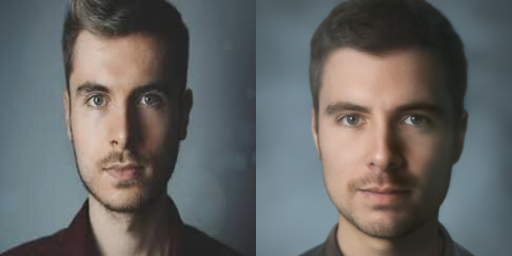

In [133]:
with torch.no_grad():
    tic = time.time()
    images, latent_real_img = run_on_batch(transformed_image.unsqueeze(0), net)
    result_image, latent = images[0], latent_real_img[0]
    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

# Display inversion:
display_alongside_source_image(tensor2im(result_image), original_image)

## Let's decode our obtained latent vector back to image, but using Stylegan2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [137]:
import torch
from model import Generator

g_ema = Generator(1024, 512, 8)

g_ema.load_state_dict(torch.load('/content/drive/MyDrive/stylegan2-ffhq-config-f (1).pt')["g_ema"], strict=False)
g_ema.eval()
g_ema = g_ema.cuda()

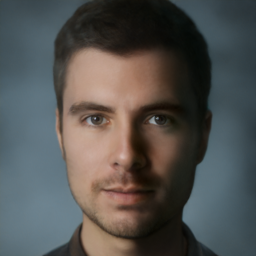

In [138]:
img_gen, _ = g_ema([latent_real_img], input_is_latent=True, randomize_noise=False)
result_image = ToPILImage()(make_grid(img_gen.detach().cpu(), normalize=True, scale_each=True, padding=0))
result_image.resize((256,256))

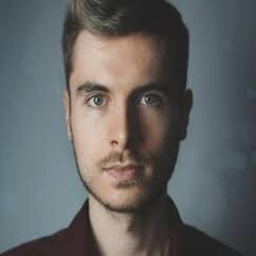

In [139]:
original_image.resize((256,256))

## Conclusion

As you can see decoder works good, as stylegan2 almost perfectly recovers the image!